Image manipulation demonstration created by Alex Frye, for use in Dr. Hoover's EE/CENG 441/541 Computer Vision class

In [1]:
import skimage
from skimage import io
from skimage import data
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
from scipy import signal
from skimage.transform import resize

In [2]:
set1 = [io.imread('aligned_images/bicycle.bmp'), io.imread('aligned_images/motorcycle.bmp')]
set2 = [io.imread('aligned_images/cat.bmp'), io.imread('aligned_images/dog.bmp')]
set3 = [io.imread('aligned_images/einstein.bmp'), io.imread('aligned_images/marilyn.bmp')]
set4 = [io.imread('aligned_images/plane.bmp'), io.imread('aligned_images/bird.bmp')]
set5 = [io.imread('aligned_images/fish.bmp'), io.imread('aligned_images/submarine.bmp')]

Functions for image manipulation, called below in the questions and tasks

In [3]:
def convolv_2d_grayscale(image, kernel, mode='constant', boundary='0'):
    
    image = skimage.img_as_float(image)
    
    im_shape = np.shape(image)
    im_x = im_shape[0]
    im_y = im_shape[1]
    
    kernel = np.fliplr(np.flipud(kernel))
    kernel_shape = np.shape(kernel)
    k_x = int((kernel_shape[0] - 1) / 2)
    k_y = int((kernel_shape[1] - 1) / 2)
    new_image = np.zeros(im_shape)
    
    if mode == 'constant':
        image = np.lib.pad(image, (k_x, k_y), 'constant', constant_values=(boundary, boundary))
    elif mode == 'edge':
        image = np.lib.pad(image, (k_x, k_y), 'edge')
   
    for i in range(im_x):
        for j in range(im_y):
            new_image[i, j] = np.max([0, np.min([1, np.sum(image[i : i + 2*k_x + 1, j : j + 2*k_y + 1] * kernel)])])
    
    return new_image

In [4]:
def my_imfilter(image, kernel, mode='constant', boundary='0'):
    kernel_shape = np.shape(kernel)
    im_shape = np.shape(image)
    k_x = kernel_shape[0] - 1
    k_y = kernel_shape[1] - 1
    
    if len(kernel_shape) != 2 or k_x % 2 != 0 or k_y % 2 != 0:
        print("Please enter an odd-dimension kernel")
        return None
    
    if mode != 'constant' and mode != 'edge':
        print("Invalid mode")
        return None

    if len(im_shape) == 2:
        # Grayscale image
        #print('grayscale image')
        image = convolv_2d_grayscale(image, kernel, mode, boundary)
    elif len(im_shape) == 3:
        # RGB image
        #print('rgb image')
        for i in range(im_shape[2]):
            image[:,:,i] = convolv_2d_grayscale(image[:,:,i], kernel, mode, boundary)
    else:
        print('Image error')
        return None
    
    return image

In [5]:
def gaussian_2d(stdev, shape):
    
    side_x = int((shape[0] - 1) / 2)
    side_y = int((shape[1] - 1) / 2)
    x = np.arange(-side_x, side_x + 1, 1, dtype=float)[None]
    y = np.arange(-side_y, side_y + 1, 1, dtype=float)[None]
    x = 1 / (stdev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / stdev) ** 2)
    y = 1 / (stdev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (y / stdev) ** 2)
    temp = x.T @ y
    temp /= np.sum(temp)
    return temp
    

# Assumes both images are either grayscale or RGB, not one of each
def make_images_same_size(image1, image2, mode='edge'):
    im1 = np.array(np.shape(image1))
    im2 = np.array(np.shape(image2))
    if len(im1) != 2 and len(im1) != 3 or len(im2) != 2 and len(im2) != 3:
        return None, None, False
    if im1[0] == im2[0] and im1[1] == im2[1]:
            return image1, image2, True
    if im1[0] < im2[0]:
        padding = im1 * 0
        padding[0] = im2[0] - im1[0]
        image1 = np.lib.pad(image1, padding, mode)
    elif im2[0] < im1[0]:
        padding = im2 * 0
        padding[0] = im1[0] - im2[0]
        image2 = np.lib.pad(image2, padding, mode)
    if im1[1] < im2[1]:
        padding = im1 * 0
        padding[1] = im2[1] - im1[1]
        image1 = np.lib.pad(image1, padding, mode)
    elif im2[1] < im1[1]:
        padding = im2 * 0
        padding[1] = im1[1] - im2[1]
        image2 = np.lib.pad(image2, padding, mode)
    return image1, image2, True
    
    
def hybrid_fourier_grayscale(image1, image2, stdev=24, delta=8, show=False):
    
    shape = np.shape(image1)
    
    fft1 = np.fft.fft2(image1)
    fft1 = np.fft.fftshift(fft1)
    fft2 = np.fft.fft2(image2)
    fft2 = np.fft.fftshift(fft2)
    
    filter1 = gaussian_2d(stdev, shape)
    mx = np.max(filter1)
    filter1 = 1/mx * filter1
    
    stdev2 = stdev + delta
    filter2 = gaussian_2d(stdev2, shape)
    mx = np.max(filter2)
    filter2 = 2 - (filter2 / mx)
    
    fft1_f = fft1 * filter1
    fft2_f = fft2 * filter2
    
    fft1_fs = np.fft.ifftshift(fft1_f)
    image1_f = np.real(np.fft.ifft2(fft1_fs))
    fft2_fs = np.fft.ifftshift(fft2_f)
    image2_f = np.real(np.fft.ifft2(fft2_fs))
    
    hybrid_image = 0.5 * (image1_f + image2_f)
    
    if show:
        plt.figure(figsize=(15, 20))
        plt.subplot(421)
        plt.imshow(image1, cmap='gray')
        plt.axis('off')
        plt.title('Image 1')
        plt.subplot(422)
        plt.imshow(image2, cmap='gray')
        plt.axis('off')
        plt.title('Image 2')
        plt.subplot(423)
        plt.imshow(20*np.log10(np.abs(fft1)), cmap='gray')
        plt.axis('off')
        plt.title('Image 1 fft')
        plt.subplot(424)
        plt.imshow(20*np.log10(np.abs(fft2)), cmap='gray')
        plt.axis('off')
        plt.title('Image 2 fft')
        plt.subplot(425)
        plt.imshow(20*np.log10(np.abs(filter1)), cmap='gray')
        plt.axis('off')
        plt.title('Image 1 filter')
        plt.subplot(426)
        plt.imshow(20*np.log10(np.abs(filter2)), cmap='gray')
        plt.axis('off')
        plt.title('Image 2 filter')
        plt.subplot(427)
        plt.imshow(20*np.log10(np.abs(fft1_f)), cmap='gray')
        plt.axis('off')
        plt.title('Image 1 fft filtered')
        plt.subplot(428)
        plt.imshow(20*np.log10(np.abs(fft2_f)), cmap='gray')
        plt.axis('off')
        plt.title('Image 2 fft filtered')
        
        plt.figure(figsize=(15, 10))
        plt.subplot(221)
        plt.imshow(image1_f, cmap='gray')
        plt.axis('off')
        plt.title('Image 1 filtered')
        plt.subplot(222)
        plt.imshow(image2_f, cmap='gray')
        plt.axis('off')
        plt.title('Image 2 filtered')
        plt.subplot(223)
        plt.imshow(hybrid_image, cmap='gray')
        plt.axis('off')
        plt.title('Hybrid image')
    
    return hybrid_image

def hybrid_fourier(image1, image2, stdev=24, delta=8, show=False):
    
    image1 = skimage.img_as_float(image1)
    image2 = skimage.img_as_float(image2)
    
    im1_shape = np.shape(image1)
    im2_shape = np.shape(image2)
    if im1_shape != im2_shape:
        print("Please enter images of the same size")
        return None
    
    if len(im1_shape) == 2:
        # Grayscale image
        #print('grayscale image')
        image1 = hybrid_fourier_grayscale(image1, image2, stdev, delta, show)
    elif len(im1_shape) == 3:
        # RGB image
        #print('rgb image')
        for i in range(im1_shape[2]):
            image1[:,:,i] = hybrid_fourier_grayscale(image1[:,:,i], image2[:,:,i], stdev, delta, show)
    else:
        print('Image error')
        return None
    
    return image1

def hybrid_convolution(image1, image2, stdev=24, delta=8):
    
    shape = [stdev * 3, stdev * 3]
    filter1 = gaussian_2d(stdev, shape)
    stdev2 = stdev + delta
    shape = [stdev2 * 3, stdev2 * 3]
    filter2 = -gaussian_2d(stdev2, shape)
    filter2[int(shape[0] / 2),int(shape[1] / 2)] = -2 * np.sum(filter2) + filter2[int(shape[0] / 2),int(shape[1] / 2)]
    image1 = my_imfilter(image1, filter1, 'edge')
    image2 = my_imfilter(image2, filter2, 'edge')
    return 0.5 * (image1 + image2)

def hybrid_image(image1, image2, stdev=24, delta=8, method='fourier'):
    
    image1 = skimage.img_as_float(image1)
    image2 = skimage.img_as_float(image2)
    
    image1, image2, ret = make_images_same_size(image1, image2)
    if not ret:
        print('Invalid Images, check dimensions')
        return None
    
    if method == 'fourier':
        return hybrid_fourier(image1, image2, stdev, delta)
    elif method == 'convolution':
        return hybrid_convolution(image1, image2, stdev, delta)
    else:
        print("Invalid method")
        return None
        

In [6]:
def plot_kernel_image_time(im_steps, k_min, k_max, k_step, mode='scipy', n_measurements=5):
    
    if k_min % 2 == 0:
        k_min += 1
    if k_step % 2 != 0:
        k_step += 1
    
    #im_steps = np.arange(im_min, im_max, im_step)
    k_steps = np.arange(k_min, k_max, k_step)
    
    results = np.zeros((len(im_steps), len(k_steps)))
    for useless in range(n_measurements):
        pct = useless / n_measurements * 100
        print(str(pct) + '% completed')
        start2 = time.time()
        for i in range(len(im_steps)):
            for j in range(len(k_steps)):
                im = np.full((im_steps[i], im_steps[i]), 0.5)
                k = np.full((k_steps[j], k_steps[j]), 0.5)
                start = time.time()
                if mode == 'custom':
                    im = convolv_2d_grayscale(im, k)
                elif mode == 'scipy':
                    im = signal.convolve2d(im, k)
                else:
                    print('Invalid mode')
                    return
                results[i,j] += (time.time() - start) / n_measurements
        delta2 = time.time() - start2
        print('Estimated time remaining: ' + str(delta2 * (n_measurements - useless - 1)))
    
    x, y = np.meshgrid(im_steps, k_steps)
    print(x)
    print(y)
    print(results)
    fig = plt.figure()
    fig.set_size_inches(11,8)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(y.T, x.T, results)

    # Customize the z axis.
    ax.set_zlim(0, np.max(results))
    ax.set_xlabel('Kernel size (pixels)')
    ax.set_ylabel('Image size (pixels)')
    ax.set_zlabel('Computation Time (seconds)')
            

Question 1: Explicitly describe image convolution: the input, the transformation, and the output. 
Why is it useful for computer vision?

In the frequency domain, low-pass-filtering an image is done by creating a function (usually a gaussian) that suppresses high-frequency content in the image. Then, the function and image are multiplied together, and the result converted back into the time-domain. This can be compute-intensive, and the conversion to frequency-domain and back is unneccessary. That multiplication in the frequency domain can be done in the time-domain using convolution.

Image convolution has two main components: the image, and the kernel to be convolved with it. To convolve the kernel with the image, it is run on every pixel of the input image, and the sum of each step is used as the pixel value of the ourput image. For example, with a 3x3 low-pass filtering kernel, each entry will be 1/9. Convolving this with the image results in each pixel of the output image being the average of the 9 pixels around and including the current pixel. This leaves a question as to what happens at the edges of the image, where there are no image pixels to use in those computations. This requires the use of some boundary extrapolation. There are a few different methods here, namely using a constant value or copying the edge pixels and extending the image.

As an example, here is an image of a cat, and a low-pass filtered version, done using convolution

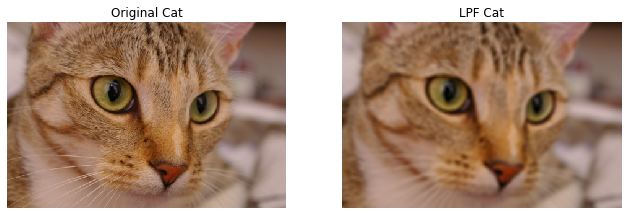

In [7]:
cat = skimage.img_as_float(data.chelsea())
fig = plt.figure()
fig.set_size_inches(11,8)
plt.subplot(121)
plt.axis('off')
plt.title('Original Cat')
plt.imshow(cat)

plt.subplot(122)
plt.axis('off')
plt.title('LPF Cat')
plt.imshow(hybrid_image(cat, cat, 3, 0, 'convolution'))

Question 2: What is the difference between convolution and correlation? Construct a scenario that 
produces a different output between both operations and show some images of the result.

Correlation and Convolution are very similar, but not quite the same. Convolution is the same as correlation, except that at the start the kernel is flipped vertically and horizontally. Coincidentally, these operations are identical when the kernel is both vertically and horizontally symmetrical.

Here is an example of a different output with an asymmetrical kernel. The kernel finds edges from one side of the image to the other, so the convolution/correlation difference results in the edges being lighter in one and darker in the other

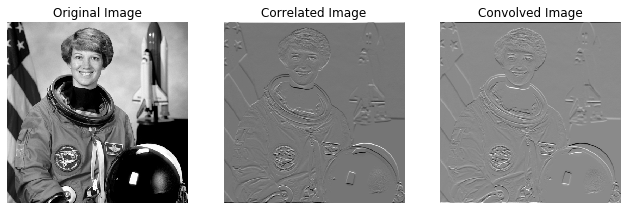

In [8]:
brick = skimage.color.rgb2gray(skimage.img_as_float(data.astronaut()))

k = [[-1/3, -1/3, -1/3], [0, 0, 0], [1/3, 1/3, 1/3]]

fig = plt.figure()
fig.set_size_inches(11,8)
plt.subplot(131)
plt.axis('off')
plt.title('Original Image')
plt.imshow(brick, cmap='gray')

plt.subplot(132)
plt.axis('off')
plt.title('Correlated Image')
plt.imshow(signal.correlate2d(brick, k), cmap='gray')

plt.subplot(133)
plt.axis('off')
plt.title('Convolved Image')
plt.imshow(signal.convolve2d(brick, k), cmap='gray')

Question 3: What is the difference between a high pass flter and a low pass flter in how they 
are constructed and what they do to the image? Please provide example kernels and output 
images

High-pass filters let high-frequency information, such as edges in an image, through to the final image, while suppressing low-frequency information like ripples and gradual color shifts. An example of a high-pass filter is is a 3x3 kernel with a weight of 17/9 in the center and -1/9ths in each other cell.

Low-pass filters are the opposite, removing the edges in images. An example of a low-pass filter is a 3x3 kernel with a weight of 1/9th in each cell.

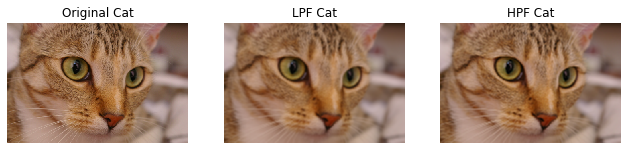

In [9]:
cat = skimage.img_as_float(data.chelsea())
fig = plt.figure()
fig.set_size_inches(11,8)
plt.subplot(131)
plt.axis('off')
plt.title('Original Cat')
plt.imshow(cat)

lpf = np.full((5, 5), 1/25)
plt.subplot(132)
plt.axis('off')
plt.title('LPF Cat')
plt.imshow(my_imfilter(cat, lpf, 'edge'))

hpf = np.full((5, 5), -1/25)
hpf[2][2] = (25*2-1)/25
plt.subplot(133)
plt.axis('off')
plt.title('HPF Cat')
plt.imshow(my_imfilter(cat, hpf, 'edge'))

Question 4: How does computation time vary with filter sizes from 15×15 to 3×3 (for all odd and
square sizes), and with image sizes from 0.25 MPix to 8 MPix (choose your own intervals)?

This test takes about a minute, so be wary of that.

The time to compute an image convolution should scale with the square of image size and the square of kernel size. In the example below, computing a 3000x3000 (9M Pixel) image with a 15x15 kernel takes 6.69 seconds, while a 2500x2500 (6.25M Pixel) image with the same kernel takes only 4.65 seconds. Assuming a square relationship in image size, 3000^2 / 2500^2 = 1.44, while the time ratio is 6.69 / 4.65 = 1.43. This is impressively close, and this measurement is the average of 5 seperate tests.

On the kernel side, the relationship is still n^2, and that shows in the data as well. Computing a 3000x3000 (9M Pixel) image with a 15x15 kernel takes 6.69 seconds, while the same image with a 13x13 kernel takes only 5.11 seconds. Assuming a square relationship in image size, 15^2 / 13^2 = 1.33, while the time ratio is 6.69 / 5.11 = 1.31. Again, impressively close.

0.0% completed
Estimated time remaining: 0.0
[[ 500  600  750 1000 1500 2000 2500 3000]
 [ 500  600  750 1000 1500 2000 2500 3000]
 [ 500  600  750 1000 1500 2000 2500 3000]
 [ 500  600  750 1000 1500 2000 2500 3000]
 [ 500  600  750 1000 1500 2000 2500 3000]
 [ 500  600  750 1000 1500 2000 2500 3000]
 [ 500  600  750 1000 1500 2000 2500 3000]]
[[ 3  3  3  3  3  3  3  3]
 [ 5  5  5  5  5  5  5  5]
 [ 7  7  7  7  7  7  7  7]
 [ 9  9  9  9  9  9  9  9]
 [11 11 11 11 11 11 11 11]
 [13 13 13 13 13 13 13 13]
 [15 15 15 15 15 15 15 15]]
[[0.01200151 0.03192019 0.05086398 0.08132386 0.11133146 0.1591382
  0.18550634]
 [0.01695824 0.04288554 0.0681951  0.11622429 0.15156746 0.20342851
  0.26531744]
 [0.02693081 0.066818   0.10472298 0.18505216 0.23209953 0.31270218
  0.41087198]
 [0.04585218 0.11865115 0.18552971 0.32990694 0.41086817 0.55458212
  0.72288108]
 [0.10471821 0.2646966  0.42472506 0.72626495 0.9289639  1.25315619
  1.64745116]
 [0.18248487 0.47218752 0.74615002 1.28337193 1.631795

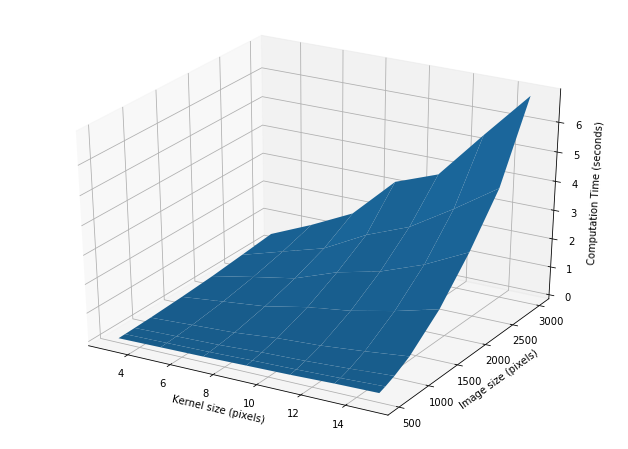

In [10]:
plot_kernel_image_time([500, 600, 750, 1000, 1500, 2000, 2500, 3000], 3, 16, 2, 'scipy', 1)

The my_imfilter function is written above, and calls the convolv_2d_grayscale function for grayscale images, and on each slice of a color image. Currently this function is quite slow, on the order of 1000 times slower than teh scipy convolution function for 500x500 images. I can't quite see how to speed this up that much, except by removing the nested for loop at the end of convolv_2d_grayscale, but then what numpy function to replace it with? At the very least, it works, and returns errors for incorrectly-dimensioned kernels and images alike. This function is tested below, as well as in question 2.

Hybrid Images

Both the convolution and fourier transform methods are coded and tested here. The only real difference is that the fourier function is significantly faster.

Below is an example of each step in the fourier-method hybrid image creation. First, each image is fourier transformed, and shifted so that the DC term is in the center. Then, a high-pass and low-pass gaussian are created, and scaled so that the maximim value is 1. Finally, each filter is multiplied by its respective image and then converted back to the time domain, where the images are averaged to create the hybrid image.

array([[0.3276219 , 0.32093216, 0.32324969, ..., 0.48392072, 0.48184572,
        0.47852142],
       [0.30995635, 0.30690253, 0.30526542, ..., 0.45975466, 0.45899709,
        0.45776109],
       [0.30838038, 0.30202576, 0.30118933, ..., 0.4624904 , 0.45787253,
        0.45550958],
       ...,
       [0.16228906, 0.15299733, 0.15501823, ..., 0.23794063, 0.2409744 ,
        0.22448908],
       [0.16402388, 0.14943097, 0.14946154, ..., 0.23198814, 0.22971721,
        0.22979064],
       [0.14164276, 0.13188603, 0.12834472, ..., 0.20524333, 0.20480142,
        0.19975911]])

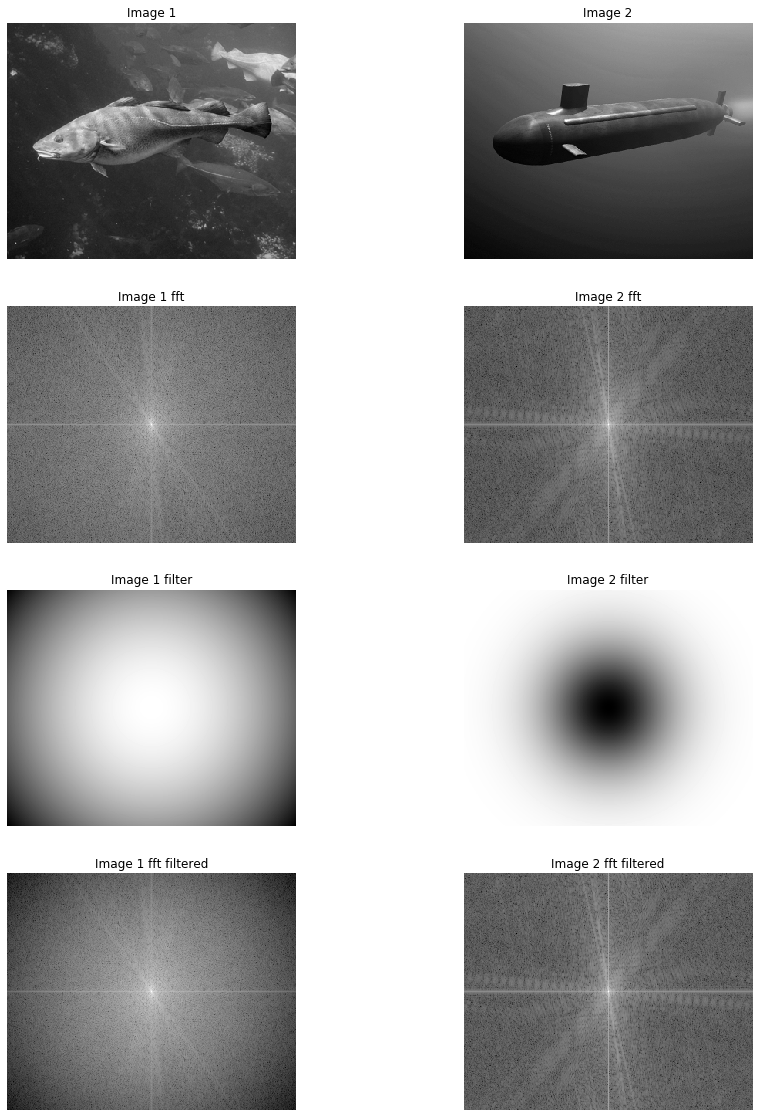

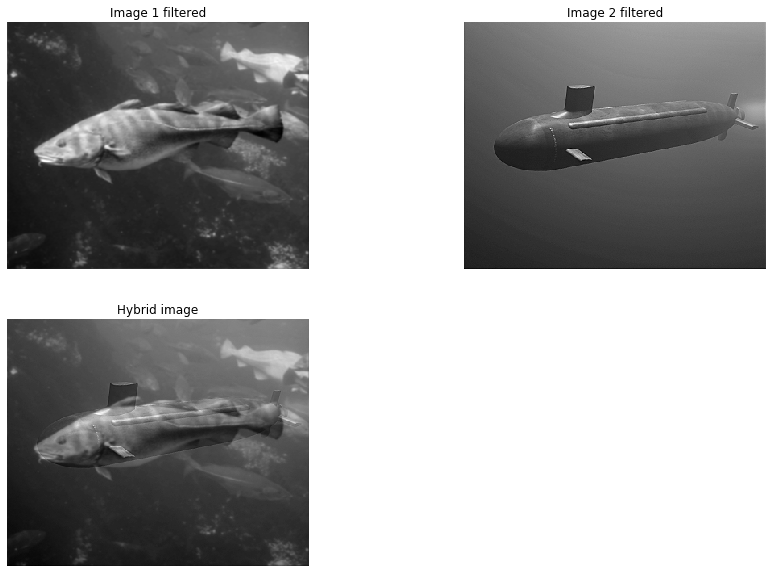

In [11]:
im1 = skimage.color.rgb2gray(set5[0])
im2 = skimage.color.rgb2gray(set5[1])
hybrid_fourier(im1, im2, 64, 0, True)

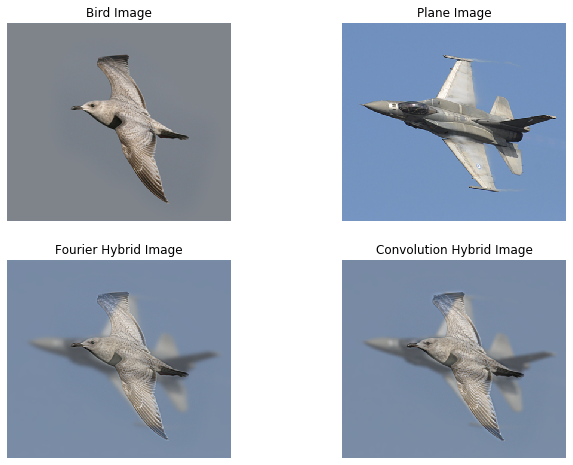

In [12]:
fig = plt.figure()
fig.set_size_inches(11,8)

plt.subplot(221)
plt.title('Bird Image')
plt.axis('off')
plt.imshow(set4[1])

plt.subplot(222)
plt.title('Plane Image')
plt.axis('off')
plt.imshow(set4[0])

plt.subplot(223)
plt.title('Fourier Hybrid Image')
plt.axis('off')
plt.imshow(hybrid_image(set4[0], set4[1], 16, 16, 'fourier'))

plt.subplot(224)
plt.title('Convolution Hybrid Image')
plt.axis('off')
plt.imshow(hybrid_image(set4[0], set4[1], 3, 1, 'convolution'))

Image Pyramid

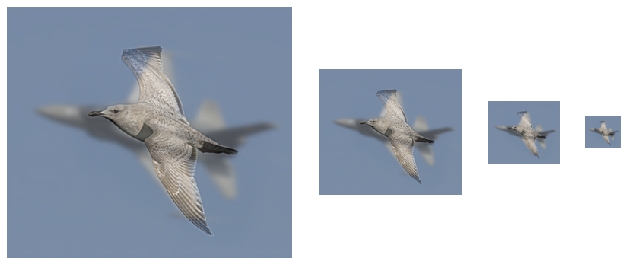

In [13]:
fig = plt.figure()
fig.set_size_inches(11,8)
gs = gridspec.GridSpec(1, 4, width_ratios=[8, 4, 2, 1]) 
temp = hybrid_image(set4[0], set4[1], 16, 16, 'fourier')
for i in range(1, 5):
    plt.subplot(gs[i-1])
    plt.axis('off')
    plt.imshow(temp)
    shape = np.shape(temp)
    temp = resize(temp, (int(shape[0]/2), int(shape[1]/2)))